Now, taking the resampled spectra, we need to convert from pixels to wavelengths in Angstroms. 

In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
import reduction_utils.wavelength_calibration as wc
from astropy.io import fits
import os

First load in a telluric spectrum which will help us locate features in the observed stellar spectra.

In [3]:
path_to_acam_utils = os.path.dirname(wc.__file__)
print(wc.__file__)
tell_table = np.loadtxt(path_to_acam_utils+'/line_lists/tellurics_halpha.dat')
tell_wvl = tell_table[:,0]
tell_flux = tell_table[:,1]

/home/astro/phrgmk/python-path/reduction_utils/wavelength_calibration.py


And load in a reference stellar spectrum (ATLAS9 model) for further help in locating lines.

These ATLAS9 models are divided into subdirectories depending on the stellar metallicity [Fe/H] and then split by effective temperature.

For this example (HAT-P-44), [Fe/H] = +0.33 and Teff = 5295. However, the models are spaced by 0.5 in [Fe/H] and 250K in Teff so we need to load in a model with a metallicity of +0.5 ('p05') and Teff=5500K, so the model's name is:

ckp05_5500.fits within the atlas9/ckp05/ directory.


In [4]:
# load relevant spectrum from file

syn_table = fits.open(path_to_acam_utils+'/atlas9/ckp00/ckp00_6000.fits')[1].data

syn_wvl = syn_table.field('WAVELENGTH') # in Angstroms

# Now we further need to locate the model with the correct surface gravity. For H44, this is 4.46, or 'g45' in ATLAS9 speak
syn_flux = syn_table.field('g40') # g in logg * 10, ie logg = 2.0 = g20

relevant_indices = ((syn_wvl > 3000) & (syn_wvl < 9500))
syn_wvl = syn_wvl[relevant_indices]
syn_flux = syn_flux[relevant_indices]

And load in the stellar spectra and the arc solution which will serve as a guide.

In [7]:
parent_direc = '/storage/astro2/phrgmk/Data/EFOSC/WASP-94A/reduction_26/'

s1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','rb'))
nframes = len(s1)
print(nframes)
arc_solution_1 = pickle.load(open(parent_direc+'pickled_objects/arc_solution_trace2_rascal.pickle','rb'))
arc_solution_2 = arc_solution_1 # this is because for this example we only need 1 arc solution (see notebook 2)
print(s1)

477
[[ 34110.08165239  33037.56295755  31987.70856087 ...  76133.05536992
   76240.29510892  75300.37441987]
 [ 33540.61887269  32613.44557687  31926.09586766 ...  75749.76428171
   75928.62749931  75279.57688439]
 [ 34081.97216002  33398.49930056  32400.98816457 ...  75491.91357046
   75931.87179873  75283.63152916]
 ...
 [ 38452.14030068  37266.72560433  37259.33547585 ... 110438.35070856
  110484.75813196 109111.11274673]
 [ 37929.33452975  37765.74930898  37893.85790161 ... 109800.30366665
  109574.08493622 108956.3869587 ]
 [ 37697.75344093  37130.41336799  37721.47189128 ... 110282.85592001
  109461.3036056  109045.65695399]]


Here we'll use the same lines as used in the resampling but it's not strictly necessary to use the same lines. 

In [8]:
#ref_lines = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/ref_lines.pickle','rb'))


Now plot the model, telluric and stellar spectrum on the same plot to help identify the lines.

<IPython.core.display.Javascript object>


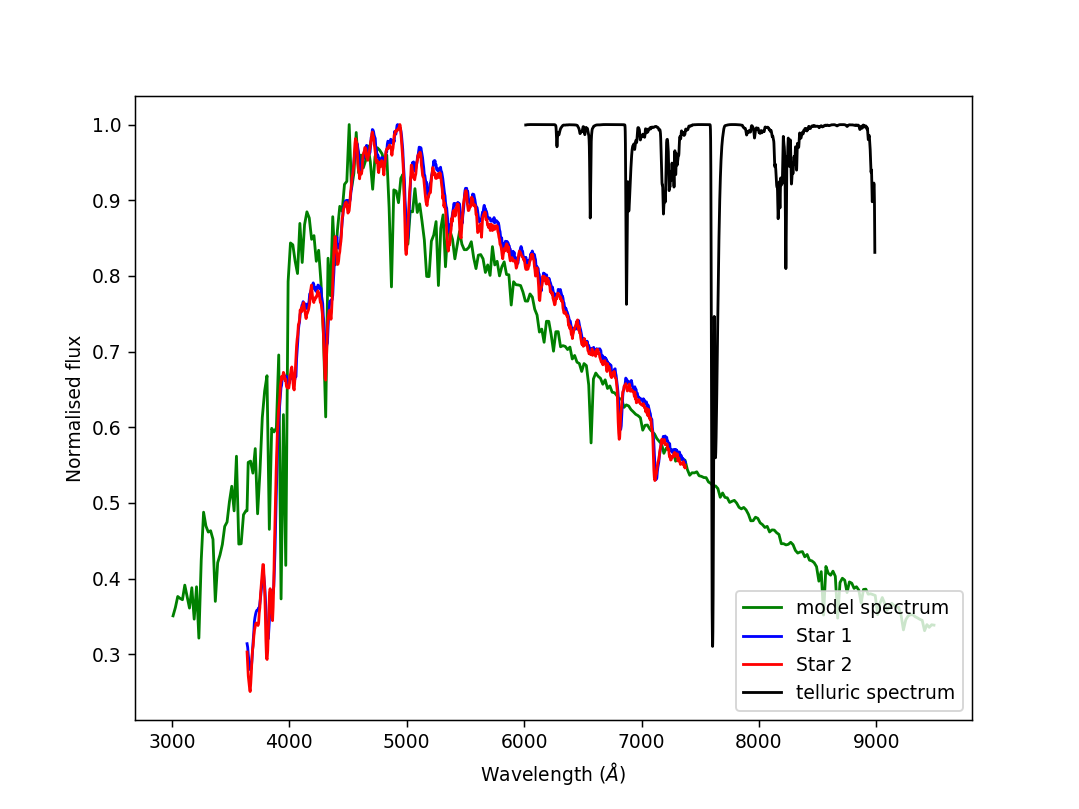

In [9]:
nframes = len(s1)

plt.figure(figsize=(8,6))

plt.plot(syn_wvl,wc.normalise(syn_flux,maximum=True),'g',label='model spectrum')
plt.plot(arc_solution_1,wc.normalise(s1[80],maximum=True),'b',label='Star 1')
plt.plot(arc_solution_1,wc.normalise(s2[nframes//2],maximum=True),'r',label='Star 2')
plt.plot(tell_wvl,tell_flux,'k',label='telluric spectrum')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised flux')
plt.legend(loc='lower right')

plt.show()

So at first glance, we can see that the arc solution is off from the truth by about 30A.

Now we can use the lines and positions from the model & telluric spectra to find the corresponding lines in the stellar spectra. 

NIST ( https://physics.nist.gov/PhysRefData/Handbook/Tables/findinglist.htm ) is a useful resource for identifying absorption lines and their wavelengths. However, this doesn't include molecules that are prominent in the telluric spectra (e.g. O2).

I have listed some common ones which we can identify in our spectra below. Wavelengths given in air.


In [281]:
other_line = 3580
Ca_K = 3934
Ca_H = 3968 
FeII = 4251
some_line = 4309
Hbeta = 4861
MgbIII = np.mean([5167,5173,5184]) # this triplet is blended in our spectra
NaD = np.mean([5890,5896]) # the sodium doublet is also blended
Halpha = 6563 
Tell1 = 6871 # A telluric line whose wavelength was calculated with a Gaussian
#Tell2 = 7186 # A telluric line whose wavelength was calculated with a Gaussian
#O2 = 7605
#Ca1 = 8498  
#Ca2 = 8542
#Ca3 = 8662

Now create a dictionary where we clip the appropriate wavelengths from the arc solutions around each absorption line.

In [359]:
star1_regions = {Ca_K:np.arange(3780,3840),Ca_H:np.arange(3830,3890), some_line:np.arange(4280,4340),\
                 Hbeta:np.arange(4950,5050),MgbIII:np.arange(5300,5400),NaD:np.arange(6080,6180),\
                 Halpha:np.arange(6760,6860), Tell1:np.arange(7060,7160)}
#,Tell1:np.arange(6780,6980),Tell2:np.arange(7145,7256),\
#                 O2:np.arange(7487,7811),Ca2:np.arange(8527,8582),Ca3:np.arange(8632,8725)}


And now find the centres of these lines using wc.plot_and_fit_regions().

In [360]:
help(wc.plot_and_fit_regions)
help(wc.calc_wvl_solution)

Help on function plot_and_fit_regions in module reduction_utils.wavelength_calibration:

plot_and_fit_regions(stellar_spectrum, wvl_input, guess_dict, verbose=False)
    The function that takes a 1D spectrum, wavelength array and locations of absorption lines, and fits Gaussians to each absorption line. It also returns the position of the minimum flux for each line.
    Note: this could be improved by replacing the Gaussian with a Moffat fit although this is not yet implemented.
    Inputs:
    stellar_spectrum - the 1D spectrum
    wvl_input - the wavelength array
    guess_dict - the array of absorption line centres. This does not have to be 100% accurate, these are just starting guesses for the means of the Gaussians.
    verbose - True/False - plot the output or not. Default=False
    Returns:
    np.array(star_centres_gauss) - the means of the Gaussians fitted to each absorption line
    np.array(star_centres_argmin) - the locations of the minimum flux for each absorption line

He

In [361]:
import imp
imp.reload(wc)

<module 'reduction_utils.wavelength_calibration' from '/home/astro/phrgmk/python-path/reduction_utils/wavelength_calibration.py'>

In [362]:
def calculate_wavelength_solution(spectrum):
    star1_centres_gauss,star1_centres_argmin = wc.plot_and_fit_regions(spectrum,\
                                                                   arc_solution_1,\
                                                                   star1_regions,verbose=False)
    
    wvls1 = sorted(star1_regions.keys())
    
    # Define the order of the polynomial that will be used to fit the wavelength solution
    poly_order = 4

    wvl_solution,_ = wc.calc_wvl_solution(star1_centres_gauss,wvls1,poly_order,spectrum,verbose=False)
    
    return wvl_solution

In [1]:

reference_spectrum = s2[90]

star1_centres_gauss,star1_centres_argmin = wc.plot_and_fit_regions(reference_spectrum,\
                                                                   arc_solution_1,\
                                                                   star1_regions,verbose=True)


NameError: name 's2' is not defined

Now looking at the fits (in green) to the spectra (in blue) above, record the measured centres for each line. In some cases the fit is not very good and the argmin (location of the minimum flux) should be recorded. This is often true for the telluric O2-A band at 7600A.

In [364]:

star1_centres = star1_centres_gauss
#star1_centres_argmin
#np.array([30, 65, 128,270,345,514,668, 739])
print(star1_centres_gauss)


[ 34.08096675  44.13248823 131.94066324 271.77361505 346.04340946
 514.34029371 668.1866092  739.51948583]


Now fit the pixel positions and the associated wavelengths to derive the wavelength solution.

<IPython.core.display.Javascript object>


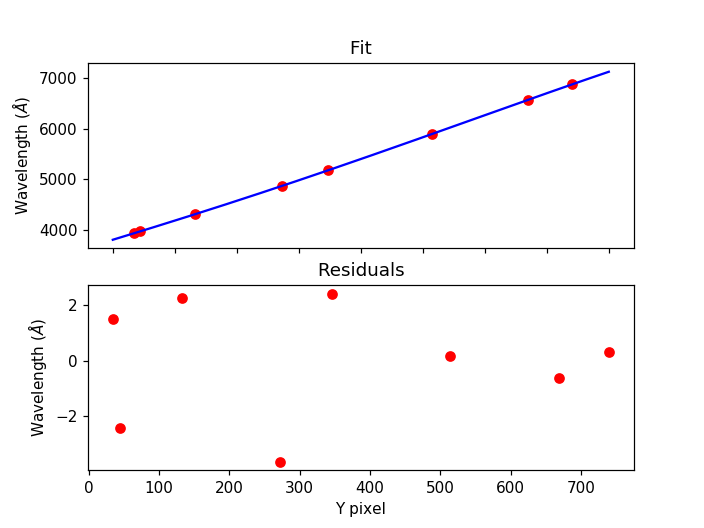

In [365]:
# extract the wavelengths from the dictionary
wvls1 = sorted(star1_regions.keys())
reference_spectrum = s2[2]
# Define the order of the polynomial that will be used to fit the wavelength solution
poly_order = 4

wvl_solution_1,_ = wc.calc_wvl_solution(star1_centres,wvls1,poly_order,reference_spectrum, verbose=True)


Now plot the wavelength solution, with the model spectra and lines used to see how well they all line up.

<IPython.core.display.Javascript object>


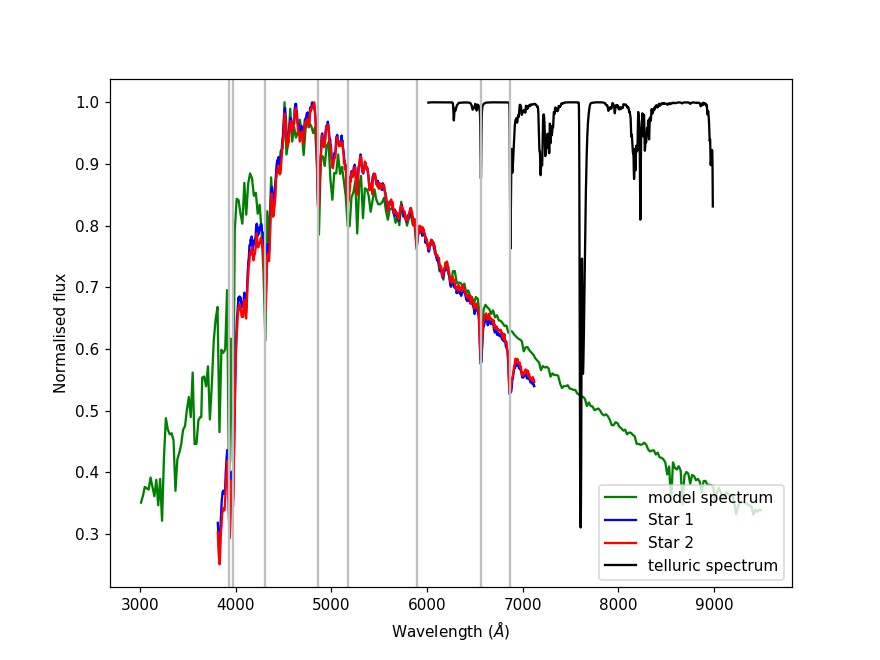

In [353]:
plt.figure(figsize=(8,6))

plt.plot(syn_wvl,wc.normalise(syn_flux,maximum=True),'g',label='model spectrum')
plt.plot(wvl_solution_1,wc.normalise(s1[nframes//2],maximum=True),'b',label='Star 1')
plt.plot(wvl_solution_1,wc.normalise(s2[nframes//2],maximum=True),'r',label='Star 2')
plt.plot(tell_wvl,tell_flux,'k',label='telluric spectrum')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised flux')
plt.legend(loc='lower right')

for i in wvls1:
    plt.axvline(i,color='0.75')
plt.show()

These look well aligned and since the stellar spectra are aligned onto the same x-axis we don't need to repeat for star 2. Now we can save the output:

And move to notebook 5 - making the spectoscopic light curves

In [366]:
wvl_solution_individual1 = []
wvl_solution_individual2 = []
for i in range(nframes):
    #print(i)
    wvl_solution_individual1.append(calculate_wavelength_solution(s1[i]))
    wvl_solution_individual2.append(calculate_wavelength_solution(s2[i]))

In [369]:
pickle.dump(wvl_solution_individual1,open(parent_direc + '/pickled_objects/improved_resampling/wavelength_solution_individual_1.pickle','wb'))
pickle.dump(wvl_solution_individual2,open(parent_direc + '/pickled_objects/improved_resampling/wavelength_solution_individual_2.pickle','wb'))

In [367]:
#wvl_solution_individual1[0] = wvl_solution_1
#wvl_solution_individual2[0] = wvl_solution_1
first = wvl_solution_individual2[0][0]
last = wvl_solution_individual2[0][-1]
diff = []
diff_last = []
for i in wvl_solution_individual2:
    diff.append(first - i[0])
    diff_last.append(last - i[-1])
    #print(first - i[0])

<IPython.core.display.Javascript object>


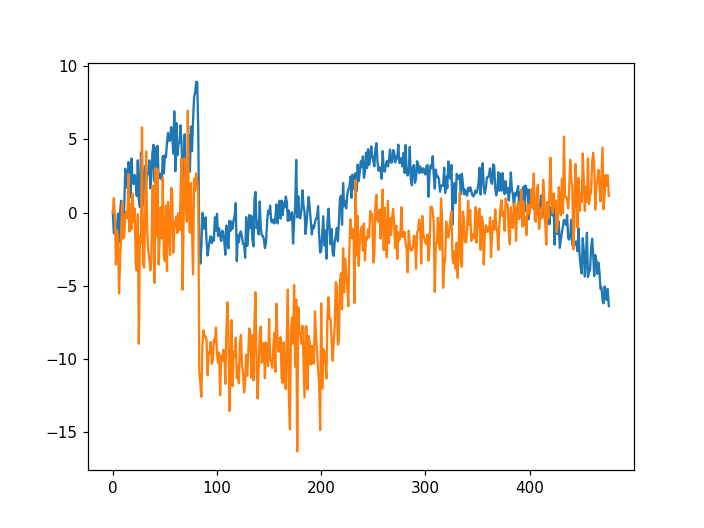

In [368]:
plt.close()
plt.plot(diff)
plt.plot(diff_last)
#plt.ylim(-100,100)